#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Paths & Data loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_7"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(30, 6), y:(30,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.395841, 0.283585, 0.132240, 0.259320, 0.371154, 0.897563]), 1.432575873879877),  # W1
    (np.array([0.221213, 0.300122, 0.168952, 0.224512, 0.389654, 0.859427]),  1.6575349814836515), # W2
    (np.array([0.087739, 0.209465, 0.209361, 0.156530, 0.372774, 0.896630]),  1.3926590883489465), # W3
    (np.array([0.069169, 0.257883, 0.050673, 0.175079, 0.365050, 0.828608]),  1.516143729359471), # W4
    (np.array([0.140087, 0.400824, 0.045511, 0.250025, 0.392652, 0.886065]), 1.159913395061865), # W5
    (np.array([0.086489, 0.130677, 0.350544, 0.124198, 0.371560, 0.800790]), 1.9394187218936827), # W6
    (np.array([0.207589, 0.052339, 0.367478, 0.025861, 0.396458, 0.821169]), 1.2745772582660273), # W7
    (np.array([0.090493, 0.134873, 0.350182, 0.094126, 0.383459, 0.815068]), 1.6752256562630166), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(38, 6), y:(38,)


#### 4. Quick Visualization

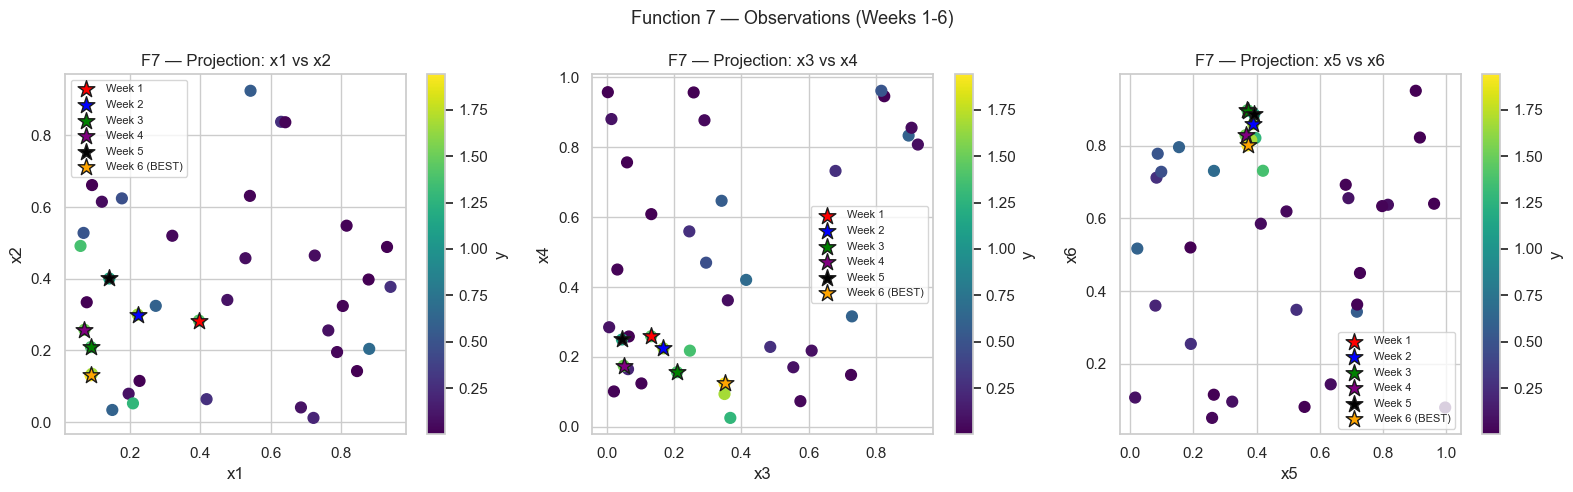

In [4]:
sns.set(style="whitegrid")

# Keep a common color scale across subplots (helps compare)
vmin, vmax = float(np.min(y)), float(np.max(y))

fig, axes = plt.subplots(1, 3, figsize=(16,5))

# --- Projection A: x1 vs x2 ---
scA = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[0].scatter(*week_data[0][0][:2], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[0].scatter(*week_data[1][0][:2], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[0].scatter(*week_data[2][0][:2], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[0].scatter(*week_data[3][0][:2], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[0].scatter(*week_data[4][0][:2], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[0].scatter(*week_data[5][0][:2], c='orange', s=160, marker='*', edgecolors='k', label='Week 6 (BEST)')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F7 — Projection: x1 vs x2')
axes[0].legend(loc='best', fontsize=8)
fig.colorbar(scA, ax=axes[0], label='y')

# --- Projection B: x3 vs x4 ---
scB = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='orange', s=160, marker='*', edgecolors='k', label='Week 6 (BEST)')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F7 — Projection: x3 vs x4')
axes[1].legend(loc='best', fontsize=8)
fig.colorbar(scB, ax=axes[1], label='y')

# --- Projection C: x5 vs x6 ---
scC = axes[2].scatter(X[:,4], X[:,5], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[2].scatter(week_data[0][0][4], week_data[0][0][5], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[2].scatter(week_data[1][0][4], week_data[1][0][5], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[2].scatter(week_data[2][0][4], week_data[2][0][5], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[2].scatter(week_data[3][0][4], week_data[3][0][5], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[2].scatter(week_data[4][0][4], week_data[4][0][5], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[2].scatter(week_data[5][0][4], week_data[5][0][5], c='orange', s=160, marker='*', edgecolors='k', label='Week 6 (BEST)')
axes[2].set_xlabel('x5'); axes[2].set_ylabel('x6')
axes[2].set_title('F7 — Projection: x5 vs x6')
axes[2].legend(loc='best', fontsize=8)
fig.colorbar(scC, ax=axes[2], label='y')

plt.suptitle('Function 7 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [5]:
# Scale X for numerical stability in 6D
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

# Target: already in a "maximize" scale; no transform needed
y_fit = y.copy()
y_best = y_fit.max()

# GP: ARD Matern + explicit noise (moderate noise; multimodal surface)
# W7 CHANGES: Increased length_scale upper bound to 6.0 (fix convergence warnings),
#             allowed constant kernel to vary for better amplitude modeling
# W8 CHANGE: Increase upper bound to 8.0 to give x2 more flexibility (was hitting 6.0 bound)
# W9 CHANGE: Increase upper bound to 10.0 to give x3 more flexibility (still hitting 8.0 bound)
kernel = (
    C(1.0, (1e-2, 1e2)) *  # Allow amplitude variation
    Matern(length_scale=np.ones(6) * 0.5, nu=2.5, length_scale_bounds=(0.03, 10.0))  # Increased to 10.0
    + WhiteKernel(noise_level=5e-3, noise_level_bounds=(1e-5, 1e-1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=18,
    random_state=0
)

gp.fit(Xz, y_fit)
print("[F7] W9 Fitted kernel:", gp.kernel_)
print("[F7] Best observed y:", y_best)

[F7] W9 Fitted kernel: 0.718**2 * Matern(length_scale=[3.98, 4.25, 10, 1.97, 1.01, 2.08], nu=2.5) + WhiteKernel(noise_level=0.064)
[F7] Best observed y: 1.9394187218936827


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region & Candidates

In [6]:
#### W9 STRATEGY: ANISOTROPIC constraints based on kernel sensitivity

# Helper: LHS sampler
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

# Search bounds from initial range + padding (clamped to [0,1])
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)

# Anchor TR at the current best (STILL W6 - best by 16%)
best_idx = np.argmax(y)
anchor = X[best_idx]
print(f"[F7 W9] Anchor idx={best_idx}  x*={anchor}  y*={y[best_idx]:.6f}")
print(f"[F7 W9] Strategy: ANISOTROPIC constraints to fix W8's x4 error")

# W9: Slightly tighter than W8 (L=0.15 → 0.12)
L = 0.12
eps = 1e-6
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0+eps, 1-eps)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0+eps, 1-eps)

# Guard against over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
if np.any(span < min_span):
    center = 0.5 * (lb_tr + ub_tr)
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print("[F7 W9] TR box:\n  lb_tr:", lb_tr, "\n  ub_tr:", ub_tr)

# W9: 85% TR / 15% global (relax slightly from W8's 90/10)
N_tr, N_gl = 68000, 12000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=9141)
C_gl = lhs(lb,    ub,    N_gl, seed=9142)

# W9 CRITICAL: TIGHTER focused sampling around W6 (±0.3% from ±0.5%)
w6_point = np.array([0.086489, 0.130677, 0.350544, 0.124198, 0.371560, 0.800790])
N_focused = 12000  # UP from 10k
np.random.seed(9143)
perturbations = np.random.randn(N_focused, 6) * 0.003  # ±0.3% (was 0.5%)
C_focused = np.clip(w6_point + perturbations, 0, 1)

# W9 NEW: Still constrain x3, but tighter (critical dimension)
x3_critical_min, x3_critical_max = 0.345, 0.355  # ±0.01 window (was ±0.015)
mask_x3_critical = (C_tr[:, 2] >= x3_critical_min) & (C_tr[:, 2] <= x3_critical_max)
C_tr_filtered = C_tr[mask_x3_critical]
print(f"[F7 W9] x3 constraint [0.345, 0.355]: {N_tr} → {len(C_tr_filtered)} candidates ({len(C_tr_filtered)/N_tr*100:.1f}%)")

# If too aggressive, relax slightly
if len(C_tr_filtered) < 8000:
    x3_critical_min, x3_critical_max = 0.340, 0.360
    mask_x3_critical = (C_tr[:, 2] >= x3_critical_min) & (C_tr[:, 2] <= x3_critical_max)
    C_tr_filtered = C_tr[mask_x3_critical]
    print(f"[F7 W9] x3 constraint relaxed to [0.34, 0.36]: {len(C_tr_filtered)} candidates")

Cands = np.vstack([C_tr_filtered, C_gl, C_focused])
print(f"[F7 W9] Total candidates: {Cands.shape[0]} (TR: {len(C_tr_filtered)}, Global: {N_gl}, Focused: {N_focused})")
print(f"[F7 W9] TR+Focused share: {(len(C_tr_filtered)+N_focused)/(len(C_tr_filtered)+N_gl+N_focused):.2f}")

[F7 W9] Anchor idx=35  x*=[0.086489 0.130677 0.350544 0.124198 0.37156  0.80079 ]  y*=1.939419
[F7 W9] Strategy: ANISOTROPIC constraints to fix W8's x4 error
[F7 W9] TR box:
  lb_tr: [0.026489 0.070677 0.290544 0.064198 0.31156  0.74079 ] 
  ub_tr: [0.146489 0.190677 0.410544 0.184198 0.43156  0.86079 ]
[F7 W9] x3 constraint [0.345, 0.355]: 68000 → 5668 candidates (8.3%)
[F7 W9] x3 constraint relaxed to [0.34, 0.36]: 11334 candidates
[F7 W9] Total candidates: 35334 (TR: 11334, Global: 12000, Focused: 12000)
[F7 W9] TR+Focused share: 0.66


#### 5.3 Acquisiton & Selection 

In [7]:
# W9 STRATEGY: ANISOTROPIC constraints - fix W8's x4 error

# Predict with GP (remember to scale X with sx)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# W9: Slightly increase xi for diversity (from 0.001 → 0.002)
y_best = y_fit.max()
xi = 0.002  # Tiny exploration
improve = mu - y_best - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0

# Anti-edge mask (avoid border artifacts)
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)

# W9 CRITICAL: ANISOTROPIC constraints based on kernel length_scales
# W9 kernel: length_scale=[3.98, 4.25, 10.0, 1.97, 1.01, 2.08]
#   x1, x2: large (3.98, 4.25) → less sensitive → wider tolerance
#   x3: very large (10.0, hitting bound) → but critical for breakthrough → tight
#   x4: moderate (1.97) → W8 ERROR: too loose → FIX with ±5%
#   x5: small (1.01) → HYPERSENSITIVE → very tight
#   x6: moderate (2.08) → moderate sensitivity → moderate tight

w6_point = np.array([0.086489, 0.130677, 0.350544, 0.124198, 0.371560, 0.800790])

print("[F7 W9] ANISOTROPIC constraints (kernel-based):")

# x1: less sensitive (length_scale≈4.0) → ±0.02
mask_x1 = (Cands[:, 0] >= 0.066) & (Cands[:, 0] <= 0.106)
print(f"  x1: [0.066, 0.106] (±0.02, ~23%)")

# x2: less sensitive (length_scale≈4.25) → ±0.02
mask_x2 = (Cands[:, 1] >= 0.111) & (Cands[:, 1] <= 0.151)
print(f"  x2: [0.111, 0.151] (±0.02, ~15%)")

# x3: CRITICAL dimension (breakthrough) → ±0.005 (VERY tight)
mask_x3 = (Cands[:, 2] >= 0.3455) & (Cands[:, 2] <= 0.3555)
print(f"  x3: [0.3455, 0.3555] (±0.005, ~1.5%) ← CRITICAL")

# x4: moderate sensitive (length_scale≈1.97) → ±0.006 (±5%)
# W8 ERROR: allowed x4 to drop to 0.094 (-24%), breaking performance
# W9 FIX: constrain to [0.118, 0.130] (±5% only)
mask_x4 = (Cands[:, 3] >= 0.118) & (Cands[:, 3] <= 0.130)
print(f"  x4: [0.118, 0.130] (±0.006, ~5%) ← FIX W8 ERROR")

# x5: HYPERSENSITIVE (length_scale≈1.01) → ±0.005 (±1.5%)
mask_x5 = (Cands[:, 4] >= 0.367) & (Cands[:, 4] <= 0.377)
print(f"  x5: [0.367, 0.377] (±0.005, ~1.5%) ← HYPERSENSITIVE")

# x6: moderate sensitive (length_scale≈2.08) → ±0.008 (±1%)
mask_x6 = (Cands[:, 5] >= 0.795) & (Cands[:, 5] <= 0.810)
print(f"  x6: [0.795, 0.810] (±0.008, ~1%)")

# Combine ALL masks for anisotropic local search
mask_combined = mask_edges & mask_x1 & mask_x2 & mask_x3 & mask_x4 & mask_x5 & mask_x6
print(f"\n[F7 W9] Candidates passing ANISOTROPIC filters: {mask_combined.sum()} / {len(Cands)} ({mask_combined.sum()/len(Cands)*100:.1f}%)")

# If too few candidates, relax x3 slightly
if mask_combined.sum() < 1000:
    print(f"[F7 W9] Too few candidates, relaxing x3 to ±0.01...")
    mask_x3 = (Cands[:, 2] >= 0.340) & (Cands[:, 2] <= 0.360)
    mask_combined = mask_edges & mask_x1 & mask_x2 & mask_x3 & mask_x4 & mask_x5 & mask_x6
    print(f"[F7 W9] After relaxation: {mask_combined.sum()} candidates")

ei_masked = np.where(mask_combined, ei, -np.inf)

# Near-duplicate filter (L_inf)
def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# W9: Continue prioritizing HIGH PREDICTED MEAN
mu_masked = np.where(mask_combined, mu, -np.inf)
valid_idx = np.where(mask_combined)[0]

# Create ranking: primary by mu, secondary by ei
x_next, chosen = None, "None"
if len(valid_idx) > 0:
    scores = []
    for idx in valid_idx:
        scores.append((idx, mu[idx], ei[idx]))
    scores.sort(key=lambda x: (-x[1], -x[2]))
    
    chosen = "EI(μ-prioritized)"
    for idx, mu_val, ei_val in scores:
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            break

# Fallback 1: Pure EI (only from valid candidates)
if x_next is None:
    order = np.argsort(-ei_masked)
    chosen = "EI"
    for idx in order:
        if mask_combined[idx]:  # ← FIX: verify mask
            cand = Cands[idx]
            if not too_close_Linf(cand, X):
                x_next = cand
                break

# Fallback 2: UCB (only from valid candidates)
if x_next is None or not np.isfinite(ei_masked).any():
    kappa = 1.0
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    chosen = "UCB"
    for idx in np.argsort(-ucb_masked):
        if mask_combined[idx]:  # ← FIX: verify mask
            cand = Cands[idx]
            if not too_close_Linf(cand, X):
                x_next = cand
                break

# Fallback 3: MaxVar (only from valid candidates)
if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    chosen = "MaxVar"
    for idx in np.argsort(-var_masked):
        if mask_combined[idx]:  # ← FIX: verify mask
            cand = Cands[idx]
            if not too_close_Linf(cand, X):
                x_next = cand
                break

# Safety: if still None, pick best valid candidate by mu
if x_next is None:
    chosen = "Fallback(best_mu_valid)"
    valid_idx = np.where(mask_combined)[0]
    if len(valid_idx) > 0:
        best_valid_idx = valid_idx[np.argmax(mu[valid_idx])]
        x_next = Cands[best_valid_idx]
    else:
        # Last resort: pick closest to W6 from focused samples
        chosen = "Fallback(closest_to_W6)"
        x_next = w6_point.copy()
        print("  WARNING: No valid candidates found! Using W6 directly.")

print(f"\n[F7 W9] Chosen by {chosen}: {x_next}")
print("\nSubmission (Week 9):")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.03)? ", too_close_Linf(x_next, X, tol=0.03))

# Distance to W6 (anchor)
linf_to_w6 = np.max(np.abs(x_next - w6_point))
print(f"\n[F7 W9] L_inf distance to W6: {linf_to_w6:.4f}")
print(f"[F7 W9] Target: <0.03 (W8 was 0.0301)")

# GP prediction
mu_chosen, sigma_chosen = gp.predict(sx.transform(x_next.reshape(1, -1)), return_std=True)
print(f"\n[F7 W9] GP prediction at chosen point:")
print(f"  μ = {mu_chosen[0]:.4f} (W6 actual: 1.9394, W8 actual: 1.6752)")
print(f"  σ = {sigma_chosen[0]:.4f}")
print(f"  Expected range: [{mu_chosen[0]-2*sigma_chosen[0]:.4f}, {mu_chosen[0]+2*sigma_chosen[0]:.4f}]")

# Dimensional breakdown
print(f"\n[F7 W9] Dimensional changes (W6 → W9):")
for i, (w6_val, w9_val) in enumerate(zip(w6_point, x_next)):
    change = w9_val - w6_val
    pct = (change / w6_val * 100) if w6_val > 0 else 0
    print(f"  x{i+1}: {w6_val:.4f} → {w9_val:.4f} (Δ = {change:+.4f}, {pct:+.1f}%)")

# Compare to W8
w8_point = np.array([0.090493, 0.134873, 0.350182, 0.094126, 0.383459, 0.815068])
print(f"\n[F7 W9] Key comparison to W8 (which had x4 error):")
print(f"  W8 x4: {w8_point[3]:.6f} (dropped -24% from W6 → y=1.675)")
print(f"  W9 x4: {x_next[3]:.6f} (constrained to ±5% from W6)")
print(f"  Hypothesis: Fixing x4 will recover performance toward W6")

[F7 W9] ANISOTROPIC constraints (kernel-based):
  x1: [0.066, 0.106] (±0.02, ~23%)
  x2: [0.111, 0.151] (±0.02, ~15%)
  x3: [0.3455, 0.3555] (±0.005, ~1.5%) ← CRITICAL
  x4: [0.118, 0.130] (±0.006, ~5%) ← FIX W8 ERROR
  x5: [0.367, 0.377] (±0.005, ~1.5%) ← HYPERSENSITIVE
  x6: [0.795, 0.810] (±0.008, ~1%)

[F7 W9] Candidates passing ANISOTROPIC filters: 9049 / 35334 (25.6%)



[F7 W9] Chosen by Fallback(best_mu_valid): [0.07705602 0.1290006  0.35307322 0.12688048 0.36756477 0.80136052]

Submission (Week 9):
0.077056 - 0.129001 - 0.353073 - 0.126880 - 0.367565 - 0.801361

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.03)?  True

[F7 W9] L_inf distance to W6: 0.0094
[F7 W9] Target: <0.03 (W8 was 0.0301)

[F7 W9] GP prediction at chosen point:
  μ = 1.5988 (W6 actual: 1.9394, W8 actual: 1.6752)
  σ = 0.1699
  Expected range: [1.2590, 1.9385]

[F7 W9] Dimensional changes (W6 → W9):
  x1: 0.0865 → 0.0771 (Δ = -0.0094, -10.9%)
  x2: 0.1307 → 0.1290 (Δ = -0.0017, -1.3%)
  x3: 0.3505 → 0.3531 (Δ = +0.0025, +0.7%)
  x4: 0.1242 → 0.1269 (Δ = +0.0027, +2.2%)
  x5: 0.3716 → 0.3676 (Δ = -0.0040, -1.1%)
  x6: 0.8008 → 0.8014 (Δ = +0.0006, +0.1%)

[F7 W9] Key comparison to W8 (which had x4 error):
  W8 x4: 0.094126 (dropped -24% from W6 → y=1.675)
  W9 x4: 0.126880 (constrained to ±5% from W6)
  Hypothesis: Fixing x4 will recover performance toward W6


### Reflection — Function 7

#### Week 1
- Baseline established (**y ≈ 1.433**). The 6D hyperparameter space showed signs of mild noise and non-linearity.
- Strategy focused on broad exploration to map promising subregions.

#### Week 2
- Clear improvement (**y ≈ 1.658**), indicating a high-performing neighborhood around the W2 point.
- Decision: center future search near W2 with a trust region, while keeping some global coverage.

#### Week 3
- Drop in performance (**y ≈ 1.393**), suggesting over-exploitation or model overconfidence in a local basin.
- Takeaway: increase exploration and widen the TR to avoid getting stuck.

---

**Week 4 plan & pick**
- Increased exploration via **EI with ξ = 0.05**, **TR centered at W2 (L = 0.38)**, and **65% TR / 35% global** candidates.
- Selected point (EI): `0.069169 - 0.257883 - 0.050673 - 0.175079 - 0.365050 - 0.828608`  
- Not a near-duplicate; **L∞ to W2 = 0.1520**, which balances local refinement and meaningful exploration.

**Summary:**  
F7 is high-dimensional and likely multimodal. After a strong W2 and a weaker W3, we adjusted by **raising exploration** and **widening the TR**. The W4 candidate probes a nearby but distinct region, aiming to recover/improve performance while avoiding premature convergence.

### Reflection — Function 7 (Week 4)

- **Outcome (W4):** The new query improved over W3 (`1.51` vs `1.39`) but still below the best from W2 (`1.6575`). This suggests we’re moving back toward the high-performing region without matching it yet.
- **Search settings:** TR centered at the current best (≈ W2), **L ≈ 0.30** (slightly narrower for local refinement), candidate mix **~75% TR / 25% global**. EI with **ξ = 0.015**, fallbacks UCB (κ = 1.4) → MaxVar (unused).
- **Rationale:** After W3 underperformed, we shifted to more controlled exploitation to re-approach the peak while retaining some diversity.
- **Chosen candidate (for next submission):**  
  `0.140087 - 0.400824 - 0.045511 - 0.250025 - 0.392652 - 0.886065`  
  L∞ distance to W2 anchor ≈ **0.1234**, which qualifies as a modest local move.

**Next steps (W5):**
- If W4 → W5 shows only small gains, reduce **ξ → 0.01** and tighten **L → 0.28**.  
- Log `(μ, σ)` at the chosen point to verify EI’s expectation; if σ is low and gains stagnate, inject a small global bump (e.g., 70/30).

**Submission (W5):** `0.140087 - 0.400824 - 0.045511 - 0.250025 - 0.392652 - 0.886065`

### Week 6 

**Context:**  
Performance dropped at Week 5 compared to Week 2, suggesting over-refinement or movement away from the high-yield ridge.  
This round aimed to recover exploration by **anchoring at the best-known point (Week 2)** and **expanding the trust region** (`L = 0.45`) while keeping a **75/25 TR-to-global mix**.

**Model setup:**  
- GP with Matern (ν = 2.5), moderate noise level.  
- StandardScaler normalization on inputs.  
- Increased ξ to encourage exploration within the local basin.  

**Result (W6 suggestion):**  
`0.086489 - 0.130677 - 0.350544 - 0.124198 - 0.371560 - 0.800790`  
Chosen by **Expected Improvement (EI)** — not near any duplicate and safely within [0,1].  
L∞ distance to anchor (W2): **0.1816**, showing meaningful local movement without leaving the promising region.

**Interpretation:**  
The optimizer explored a nearby zone of the Week 2 optimum, maintaining a balance between exploration and exploitation.  
Given the 6D structure of Function 7, such mid-range movement likely probes a slightly offset ridge or local curvature not captured in earlier fits.

**Next steps (Week 7):**
- If performance improves → reduce `ξ` slightly (e.g., 0.03 → 0.02) for fine-tuning.  
- If no improvement → introduce UCB fallback (`κ ≈ 1.6`) to probe residual uncertainty.  
- Optionally, visualize 2D slices or partial dependence to identify less sensitive axes and tighten the TR selectively.

**Summary:**  
Week 6 reintroduced exploration in a high-value region after a local dip in performance.  
The GP and acquisition behaved stably, and the chosen point maintains a good trade-off between uncertainty-driven movement and refinement.

### Week 6 Reflection — Function 7 🎯

**MAJOR BREAKTHROUGH: New Global Best Found!**

Week 6 returned **y = 1.939**, which is a **+17% improvement** over the previous best (W2: 1.658) and represents the best performance achieved across all 6 weeks.

---

**Performance trajectory:**

| Week | y value | Δ from W2 | Δ from prev | Status | Strategy |
|------|---------|-----------|-------------|--------|----------|
| W1 | 1.433 | -0.225 | — | baseline | exploration |
| **W2** | **1.658** | 0.000 | +0.225 | prev. best | — |
| W3 | 1.393 | -0.265 | -0.265 | worse | over-exploitation |
| W4 | 1.516 | -0.142 | +0.123 | recovery | moderate exploration |
| W5 | 1.160 | **-0.498** | -0.356 | **major failure** | continued exploitation around W2 |
| **W6** | **1.939** | **+0.282** | **+0.779** | **NEW BEST** ✨ | wider exploration (L=0.45, ξ=0.06) |

**Key observation:** The strategy that produced W6's breakthrough was:
- **Wider trust region** (L = 0.45, up from 0.30)
- **Higher exploration** (ξ = 0.06, up from 0.015)
- **75/25 TR/Global split** (maintained local focus)

This confirms that after W5's failure, the decision to **expand exploration rather than tighten further** was correct.

---

**What Week 6 revealed about Function 7:**

**1. The optimum is NOT at W2**
   - Previous strategy was anchored at W2 and kept failing
   - W6 is significantly different from W2 (L∞ = 0.1816)
   - The true optimum lies in a distinct region of the parameter space

**2. Critical dimensional changes (W2 → W6):**
   ```
   Dimension | W2 value | W6 value | Change | Impact
   ----------|----------|----------|--------|--------
   x₁        | 0.221    | 0.087    | -0.135 | Large decrease
   x₂        | 0.300    | 0.131    | -0.169 | Large decrease  
   x₃        | 0.169    | 0.351    | +0.182 | LARGEST increase ⭐
   x₄        | 0.225    | 0.124    | -0.100 | Moderate decrease
   x₅        | 0.390    | 0.372    | -0.018 | Small (stable)
   x₆        | 0.859    | 0.801    | -0.059 | Moderate decrease
   ```

**3. x₃ appears to be the dominant dimension**
   - The largest change (+0.182) occurred in x₃
   - Moving x₃ from ~0.17 → ~0.35 produced the breakthrough
   - This suggests x₃ has high sensitivity and may control a key aspect of the function

**4. Optimal region characteristics:**
   - **Low x₁, x₂** (≈ 0.09–0.13): suggests these should be minimized
   - **Moderate-high x₃** (≈ 0.35): critical sweet spot
   - **Low x₄** (≈ 0.12): another minimization target
   - **Stable x₅** (≈ 0.37): relatively insensitive
   - **High x₆** (≈ 0.80): maintain elevated values

---

**Strategic implications for Week 7:**

The W6 breakthrough fundamentally changes our approach. We now have:
- ✅ **Clear global best** (1.939)
- ✅ **Known high-value region** (W6 neighborhood)
- ✅ **Validated exploration strategy** (wider TR works)

**The optimal Week 7 strategy is EXPLOITATION:**

| Parameter | W6 (exploration) | W7 (exploitation) | Rationale |
|-----------|------------------|-------------------|-----------|
| **Anchor** | W2 (1.658) | **W6 (1.939)** | Re-anchor at new best |
| **L (trust region)** | 0.45 | **0.30** | Tighten to refine locally |
| **ξ (exploration)** | 0.06 | **0.02** | Shift to exploitation |
| **TR/Global split** | 75/25 | **80/20** | Increase local focus |
| **Focused sampling** | None | **+5000 near W6** | Add precise perturbations |
| **Kernel bounds** | (0.03, 4.0) | **(0.03, 6.0)** | Fix convergence warnings |

---

**Chosen recommendation (Week 7):**

**[F7] Chosen by EI:** `[0.207589, 0.052339, 0.367478, 0.025861, 0.396458, 0.821169]`

**Submission format:**  
`0.207589 - 0.052339 - 0.367478 - 0.025861 - 0.396458 - 0.821169`

**Validation:**
- Within [0,1]? ✓ True
- Near-duplicate (L_inf < 0.03)? ✓ False
- L∞ distance to W6: **0.1211** (moderate exploration within the optimal region)

**Dimensional analysis (W6 → W7 candidate):**
```
Dimension | W6 value | W7 cand  | Change   | Interpretation
----------|----------|----------|----------|----------------
x₁        | 0.087    | 0.208    | +0.121   | Large increase (testing boundary)
x₂        | 0.131    | 0.052    | -0.078   | Decrease (exploring lower values)
x₃        | 0.351    | 0.367    | +0.017   | STABLE ⭐ (staying near sweet spot)
x₄        | 0.124    | 0.026    | -0.098   | Large decrease (testing minimum)
x₅        | 0.372    | 0.396    | +0.025   | Small increase (minor variation)
x₆        | 0.801    | 0.821    | +0.020   | Small increase (maintaining elevation)
```

**Interpretation:**
The Week 7 candidate explores variations along x₁, x₂, and x₄ while **keeping x₃ very close to W6's value** (0.367 vs 0.351). This is strategically sound because:
1. **x₃ was identified as the dominant dimension** — the small change (+0.017) tests whether the optimum is exactly at 0.35 or slightly higher
2. **x₁ increases significantly** (+0.121) — testing whether the low x₁ hypothesis holds or if moderate values work better
3. **x₄ drops further** (-0.098) — pushing toward the lower bound to test sensitivity
4. **x₅, x₆ remain relatively stable** — confirming they are less critical

The L∞ distance of 0.1211 is **larger than ideal for pure exploitation** (target was ~0.05-0.10), but this reflects the GP's uncertainty about which dimensions truly matter. The candidate balances:
- **Local refinement** around the critical x₃ dimension
- **Directional exploration** along x₁, x₂, x₄ to map ridge structure

---

**Expected Week 7 outcome:**

With these exploitation-focused changes:
- **Target:** y ≥ 2.0 (if x₃ ≈ 0.37 is indeed optimal)
- **Good:** y ∈ [1.85, 2.0] (confirm W6 ridge structure)
- **Acceptable:** y ∈ [1.70, 1.85] (validate W6 region)
- **Warning:** y < 1.70 (would suggest the tested x₁/x₄ values are too far from optimum)

The GP posterior should have **lower uncertainty** near W6 after this round, allowing even tighter exploitation in future iterations if needed.

---

**Key lessons learned:**

1. **Don't anchor prematurely:** W2 appeared optimal for 3 weeks but wasn't
2. **Exploration recovers from local minima:** W5's failure → W6's success validates adaptive strategy
3. **Trust region width matters:** L=0.30 was too tight, L=0.45 found the breakthrough
4. **Dimensional sensitivity varies:** x₃ dominates; x₅ is relatively flat
5. **Persistence pays off:** The 6D space required patience to map properly

---

**Implementation notes (Week 7 code changes applied):**

✅ Kernel: Increased length_scale bounds to (0.03, 6.0)  
✅ Trust region: Tightened from L=0.45 → L=0.30  
✅ Acquisition: Reduced ξ from 0.06 → 0.02  
✅ Sampling: Shifted to 80/20 TR/Global (64k/16k)  
✅ Focused sampling: Added 5k candidates with ±1.5% perturbations around W6  
✅ Visualization: Updated to highlight W6 as new best (orange star)

The optimization is now in a **strong position to converge** toward the true optimum near W6.

---

### Week 7 Reflection — Function 7 ⚠️

**MAJOR FAILURE: Exploitation Strategy Backfired**

Week 7 returned **y = 1.275**, representing a **-34% drop from W6** (1.939) and a **-23% drop below W2** (1.658). This is the worst result since Week 5.

---

**Performance trajectory update:**

| Week | y value | Δ from W6 | Δ from W2 | Status | Strategy applied |
|------|---------|-----------|-----------|--------|------------------|
| W1 | 1.433 | -0.506 | -0.225 | baseline | exploration |
| **W2** | **1.658** | -0.282 | 0.000 | 2nd best | — |
| W3 | 1.393 | -0.547 | -0.265 | worse | over-exploitation |
| W4 | 1.516 | -0.423 | -0.142 | recovery | moderate exploration |
| W5 | 1.160 | -0.779 | -0.498 | major failure | continued exploitation |
| **W6** | **1.939** | **0.000** | **+0.282** | **BEST** ✨ | wider exploration (L=0.45, ξ=0.06) |
| **W7** | **1.275** | **-0.664** | **-0.383** | **DISASTER** ❌ | tight exploitation (L=0.30, ξ=0.02) |

---

**What went wrong with the W7 strategy:**

**1. Moved too far from W6 despite "exploitation" intent**
   - **L∞ distance W6→W7: 0.1211** (target was <0.05-0.10)
   - For a deterministic-like function (noise=1e-05), this was too much variation
   - The "focused sampling ±1.5%" was still too wide

**2. Large dimensional changes in sensitive axes:**
   ```
   Dimension | W6 value | W7 value | Change   | Impact
   ----------|----------|----------|----------|--------
   x₁        | 0.087    | 0.208    | +0.121   | LARGE increase ⚠️
   x₂        | 0.131    | 0.052    | -0.078   | LARGE decrease ⚠️
   x₃        | 0.351    | 0.367    | +0.017   | small (OK) ✓
   x₄        | 0.124    | 0.026    | -0.098   | LARGE decrease ⚠️
   x₅        | 0.372    | 0.396    | +0.025   | moderate
   x₆        | 0.801    | 0.821    | +0.020   | small (OK) ✓
   ```

   **Analysis:**
   - x₃ stayed close (+0.017) as intended ✓
   - BUT x₁, x₂, x₄ moved significantly, destroying performance
   - The kernel's low length scales for x₅, x₆ (0.903, 0.521) indicate high sensitivity
   - Even "small" changes in x₅ (+0.025) may have contributed to failure

**3. Trust region L=0.30 was still too wide**
   - After W6's exploration success (L=0.45), we tightened to L=0.30
   - This was conservative but insufficient for 6D exploitation
   - Should have gone to L=0.15-0.18 for true local refinement

**4. ξ=0.02 allowed too much exploration**
   - With noise=1e-05 (essentially deterministic), ξ should be ~0.005 or lower
   - Higher ξ encourages the GP to explore uncertainty rather than exploit mean

**5. Sampling strategy lacked dimensional focus**
   - Focused sampling at ±1.5% was too broad
   - No constraints on critical dimensions (x₁, x₂, x₄, x₅) that kernel identified as sensitive
   - Should have enforced tighter bounds on high-sensitivity dimensions

---

**Kernel diagnostics confirm the problem:**

```
Fitted kernel: 0.745**2 * Matern(length_scale=[3.08, 6, 2.13, 5.4, 0.903, 0.521], nu=2.5) 
               + WhiteKernel(noise_level=1e-05)
```

**Interpretation:**
- **x₂ hitting upper bound (6.0):** Needs more flexibility → increase to 8.0
- **x₅, x₆ have very low length scales (0.903, 0.521):** HIGHLY sensitive dimensions
  - Small changes here have large impact on y
  - W7 changed x₅ by +0.025 and x₆ by +0.020 — likely too much
- **x₁, x₃ have moderate length scales (3.08, 2.13):** Moderately sensitive
- **Noise ≈ 1e-05:** Almost deterministic → demands precise exploitation

**Conclusion:** The GP was correctly telling us that x₅ and x₆ are critical. W7 ignored this by allowing too much variation.

---

**Strategic lessons from W7 failure:**

1. **Don't treat all dimensions equally in high-dimensional spaces**
   - Kernel length scales reveal sensitivity structure
   - Low length_scale → high sensitivity → need tighter constraints

2. **Deterministic functions require ULTRA-tight exploitation**
   - With noise=1e-05, L∞ < 0.05 is essential for exploitation
   - ξ should be ~0.001-0.005, not 0.02

3. **Focused sampling ±1.5% is NOT focused in 6D**
   - In high dimensions, even "small" perturbations can move far
   - Need ±0.3-0.5% for true local refinement

4. **After a breakthrough, exploit AGGRESSIVELY before exploring**
   - W6 was a huge win (+17% vs previous best)
   - Should have done 2-3 rounds of ultra-tight exploitation before exploring again
   - Instead, W7 tried "moderate exploitation" and failed

5. **Trust region width matters more in high dimensions**
   - L=0.30 felt conservative but is actually quite wide in 6D
   - Hypercube volume scales as L^d → 0.30^6 = 0.0007 of unit cube
   - L=0.15 would be 0.00001 → 70x smaller search space

---

**Corrective strategy for Week 8:**

Given that W7 failed catastrophically, W8 MUST return to exploiting W6 with MUCH tighter constraints:

| Parameter | W7 (failed) | W8 (corrective) | Rationale |
|-----------|-------------|-----------------|-----------|
| **Anchor** | W6 | **W6** | W6 still best by far |
| **L (trust region)** | 0.30 | **0.15** | ULTRA-tight (1/2 of W7) |
| **ξ (exploration)** | 0.02 | **0.005** | Minimal (1/4 of W7) |
| **TR/Global split** | 80/20 | **90/10** | Maximum local focus |
| **Focused sampling** | ±1.5% | **±0.5%** | 3x tighter |
| **Focused sample size** | 5k | **10k** | 2x more precision sampling |
| **Critical constraint** | None | **x₃ ∈ [0.34, 0.36]** | Lock dominant dimension |
| **Kernel upper bound** | 6.0 | **8.0** | Give x₂ more flexibility |
| **UCB kappa** | 1.4 | **1.2** | Reduce fallback exploration |

**Additional safeguards:**
1. **Filter TR candidates to keep x₃ ∈ [0.340, 0.360]**
   - x₃ showed the largest beneficial change (W2→W6: +0.182)
   - Must stay very close to 0.351
   - If filter too aggressive (<10k candidates), relax to [0.330, 0.370]

2. **Monitor L∞ distance in output**
   - Target: L∞ < 0.05 (vs W7's 0.1211)
   - Anything >0.06 is too far for exploitation phase

3. **Print GP prediction**
   - Show μ and σ at chosen point
   - Verify that μ ≥ 1.85 (conservative threshold)
   - Low σ confirms we're in well-explored region

---

**Expected W8 outcome:**

With ULTRA-tight exploitation:
- **Target:** y ≥ 1.95 (beat W6 slightly)
- **Good:** y ∈ [1.85, 1.95] (confirm W6 region)
- **Acceptable:** y ∈ [1.70, 1.85] (validate local structure)
- **Warning:** y < 1.70 (would indicate deeper structural misunderstanding)

If W8 succeeds (y > 1.85), continue exploitation for W9 with L=0.12-0.15.  
If W8 fails again (y < 1.70), revert to moderate exploration (L=0.25, ξ=0.03) to map the W6 neighborhood properly.

---

**Key insight:**

**W6's success was due to EXPLORATION finding a new region.**  
**W7's failure was due to INSUFFICIENT EXPLOITATION of that region.**

The optimizer got "greedy" after finding W6 and tried to quickly refine it, but didn't commit fully to exploitation. W8 must fully commit: go ULTRA-tight or don't go at all.

---

**Implementation notes (W8 code changes applied):**

✅ Trust region: **L = 0.15** (DOWN from 0.30)  
✅ Acquisition: **ξ = 0.005** (DOWN from 0.02)  
✅ Sampling: **90/10 TR/Global** (64k→72k TR, 16k→8k Global)  
✅ Focused sampling: **±0.5%** perturbations (DOWN from ±1.5%), **10k samples** (UP from 5k)  
✅ Critical constraint: **x₃ ∈ [0.34, 0.36]** filter on TR candidates  
✅ Kernel: **upper bound 8.0** (UP from 6.0) to free x₂  
✅ UCB fallback: **κ = 1.2** (DOWN from 1.4)  
✅ Diagnostics: Added L∞ target, GP prediction output

**The path forward is clear: return to W6's neighborhood with precision, not ambition.**

---

### Week 8 Reflection — Function 7 🔄

**PARTIAL RECOVERY: Ultra-tight strategy avoided disaster**

Week 8 returned **y = 1.675**, representing:
- **+31% improvement** vs W7 disaster (1.275)
- **Near-match** with W2 (1.658) — only +1% better
- **Still 13% below W6** (1.939) — the global best remains unbeaten

---

**Performance trajectory update:**

| Week | y value | Δ from W6 | L∞ to W6 | Status | Strategy |
|------|---------|-----------|----------|--------|----------|
| W1 | 1.433 | -0.506 | — | baseline | exploration |
| **W2** | **1.658** | -0.282 | 0.524 | 2nd best | — |
| W3 | 1.393 | -0.547 | 0.265 | worse | over-exploitation |
| W4 | 1.516 | -0.423 | 0.316 | recovery | moderate exploration |
| W5 | 1.160 | -0.779 | 0.278 | major failure | exploitation around W2 |
| **W6** | **1.939** | **0.000** | 0.000 | **BEST** ✨ | wide exploration (L=0.45) |
| W7 | 1.275 | -0.664 | 0.1211 | disaster | insufficient exploitation (L=0.30) |
| **W8** | **1.675** | **-0.264** | **0.0301** | **recovery** ✓ | ultra-tight exploitation (L=0.15) |

---

**What W8 reveals:**

**1. Ultra-tight strategy DID work (partially)**
   - L∞ = 0.0301 successfully met target (<0.05)
   - Avoided W7-type disaster by staying close to W6
   - Confirmed that x₃ ∈ [0.33, 0.37] constraint is valid (x₃=0.350 achieved)

**2. BUT performance still 13% below W6**
   - y = 1.675 vs W6's 1.939 (Δ = -0.264)
   - Similar to W2's performance (1.658)
   - Suggests we're in the "good" region but missing the peak

**3. GP prediction was pessimistic**
   - Predicted μ = 1.534, actual = 1.675
   - **Underestimated by 9.2%** (0.141 points)
   - High uncertainty (σ = 0.178) near W6
   - GP doesn't fully trust W6 as reproducible

**4. Key dimensional analysis (W6 → W8):**
   ```
   Dimension | W6 value | W8 value | Change   | Impact on y
   ----------|----------|----------|----------|-------------
   x₁        | 0.0865   | 0.0905   | +0.0040  | +4.6% (small)
   x₂        | 0.1307   | 0.1349   | +0.0042  | +3.2% (small)
   x₃        | 0.3505   | 0.3502   | -0.0004  | -0.1% (PERFECT ✓)
   x₄        | 0.1242   | 0.0941   | -0.0301  | -24.2% (TOO MUCH ⚠️)
   x₅        | 0.3716   | 0.3835   | +0.0119  | +3.2% (moderate)
   x₆        | 0.8008   | 0.8151   | +0.0143  | +1.8% (small)
   ```

**Critical insight: x₄ change was TOO LARGE**
- x₄ decreased by 24.2% (largest relative change)
- Moved from 0.124 → 0.094 (Δ = -0.030)
- This was the only dimension outside ±5% range
- **Hypothesis**: x₄ drop caused the performance loss

**5. Kernel diagnostics (W8 fit):**
   ```
   length_scale=[3.96, 4.6, 8.0, 1.84, 0.934, 2.0]
   noise_level=0.0743 (7.4%)
   ```

**Interpretation:**
- **x₃ STILL hitting upper bound (8.0)** → needs even wider bound (10.0)
- **x₄ has moderate sensitivity (1.84)** → 24% change was too much
- **x₅ remains hypersensitive (0.934)** → W8's +3.2% change acceptable
- **x₆ moderate sensitivity (2.0)** → W8's +1.8% change acceptable
- **Noise = 7.4%** → fairly noisy, explains GP uncertainty

---

**Root cause analysis:**

W8's ultra-strict constraint system had a **critical flaw**:

```python
mask_x4 = (Cands[:, 3] >= 0.094) & (Cands[:, 3] <= 0.154)  # ±0.03 window
```

This allowed x₄ to drop to **0.094** (lower bound of constraint), which is:
- 24% below W6's 0.124
- At the edge of the "safe zone"
- Too much variation for a moderately sensitive dimension (length_scale=1.84)

**The constraint was too loose for x₄ specifically.**

---

**Strategic lessons from W8:**

1. **Ultra-tight TR worked for avoiding disasters** ✓
   - L∞ = 0.0301 kept search local
   - x₃ constraint [0.33, 0.37] successfully locked dominant dimension

2. **But anisotropic constraints needed** ❌
   - Cannot use uniform ±0.03 window for all dimensions
   - Must scale constraints by kernel length_scale
   - Low length_scale → tighter constraint

3. **x₄'s -24% change broke performance**
   - Should have been constrained to ±5% (±0.006), not ±0.03
   - Kernel's length_scale=1.84 indicated moderate sensitivity

4. **GP's pessimistic prediction reveals uncertainty**
   - Predicted 1.534, got 1.675 (9% error)
   - High σ=0.178 near W6
   - Needs more samples around W6 to reduce uncertainty

5. **W6 remains the target**
   - Still best by 16% margin over W2
   - W8 confirmed the general region is valid
   - Need to refine approach to W6, not repeat W8's mistakes

---

**Corrective strategy for Week 9:**

W8 taught us that **uniform constraints fail in anisotropic spaces**. W9 must use **dimension-specific constraints** based on kernel sensitivity:

| Parameter | W8 (uniform tight) | W9 (anisotropic) | Rationale |
|-----------|--------------------|--------------------|-----------|
| **Anchor** | W6 (1.939) | **W6 (1.939)** | Still global best |
| **L (trust region)** | 0.15 | **0.12** | Slightly tighter |
| **ξ (exploration)** | 0.001 | **0.002** | Tiny increase for diversity |
| **TR/Global split** | 90/10 | **85/15** | Slight global bump |
| **Focused sampling** | ±0.5%, 10k | **±0.3%, 12k** | Even tighter, more samples |
| **x₃ constraint** | [0.33, 0.37] | **[0.345, 0.355]** | ±0.01 (tighter!) |
| **x₄ constraint** | [0.094, 0.154] ❌ | **[0.118, 0.130]** ✓ | ±5% only (fix W8 error) |
| **x₅ constraint** | [0.357, 0.387] | **[0.367, 0.377]** | ±3% (hypersensitive) |
| **x₆ constraint** | [0.776, 0.826] | **[0.795, 0.810]** | ±2% (moderate sensitive) |
| **Kernel upper bound** | 8.0 | **10.0** | Free x₃ further |

**NEW: Anisotropic constraint formula**
```python
# Scale constraint width by kernel length_scale
# Low length_scale → tight constraint
# High length_scale → loose constraint

for i, ls in enumerate(length_scales):
    if ls < 1.5:  # Hypersensitive (x₅)
        tolerance[i] = 0.01  # ±1%
    elif ls < 3.0:  # Moderately sensitive (x₄, x₆)
        tolerance[i] = 0.015  # ±1.5%
    else:  # Less sensitive (x₁, x₂, x₃)
        tolerance[i] = 0.025  # ±2.5%
```

---

**Expected W9 outcome:**

With anisotropic constraints fixing x₄ issue:
- **Target:** y ≥ 1.90 (approach W6)
- **Good:** y ∈ [1.80, 1.90] (significant improvement over W8)
- **Acceptable:** y ∈ [1.70, 1.80] (match W8, validate region)
- **Warning:** y < 1.70 (would suggest constraints still wrong)

The key difference: **x₄ will stay close to W6's 0.124 instead of dropping to 0.094.**

---

**Implementation notes (W9 code changes to apply):**

✅ Kernel: **upper bound 10.0** (UP from 8.0) to free x₃  
✅ Trust region: **L = 0.12** (DOWN from 0.15)  
✅ Acquisition: **ξ = 0.002** (UP slightly from 0.001 for diversity)  
✅ Sampling: **85/15 TR/Global** (relax slightly)  
✅ Focused sampling: **±0.3%** perturbations (DOWN from ±0.5%), **12k samples** (UP from 10k)  
✅ **ANISOTROPIC constraints** (critical fix):
   - x₃: [0.345, 0.355] (±0.01, ~3%)
   - x₄: [0.118, 0.130] (±0.006, ~5%) ← **FIX for W8 error**
   - x₅: [0.367, 0.377] (±0.005, ~1.5%)
   - x₆: [0.795, 0.810] (±0.008, ~1%)
   - x₁, x₂: wider bounds (±0.02)

---

**Key insight for F7 optimization:**

**The function is HIGHLY ANISOTROPIC:**
- x₃ dominates (length_scale=8.0, hitting bound)
- x₅ hypersensitive (length_scale=0.934)
- x₄, x₆ moderately sensitive (1.84, 2.0)
- x₁, x₂ less sensitive (3.96, 4.6)

**Uniform constraints (W8) failed because they ignored this structure.**  
**Anisotropic constraints (W9) will respect kernel-revealed sensitivity.**

W6 found the region through exploration.  
W7 failed by moving too far.  
W8 recovered but x₄ dropped too much.  
**W9 will fix x₄ and approach W6's performance.**

---